In [1]:
%matplotlib notebook

In [2]:
from simple_network_utils import *

In [3]:
num_cells = 200
target_mean_rate = 10.  # Hz
random_seed = 0
target_modulation_freq = {'Theta': 7., 'Gamma': 70.}  # Hz
target_modulation_amp = {'Theta': 5., 'Gamma': 5.}  # Hz
filter_band_dict = {'Gamma': [50., 80.], 'Theta': [4., 10.]}  # Hz

In [4]:
dt = 1.  # ms
duration = 4000.  # ms
t = np.arange(0., duration, dt)
sampling_rate = 1000. / dt
filter_order = 15
sos_dict = {}
local_random = random.Random()
local_random.seed(random_seed)

In [5]:
rate = np.ones_like(t) * target_mean_rate
for band_label in target_modulation_amp:
    rate += target_modulation_amp[band_label] * np.cos(2. * np.pi * t * target_modulation_freq[band_label] / 1000.)

<IPython.core.display.Javascript object>


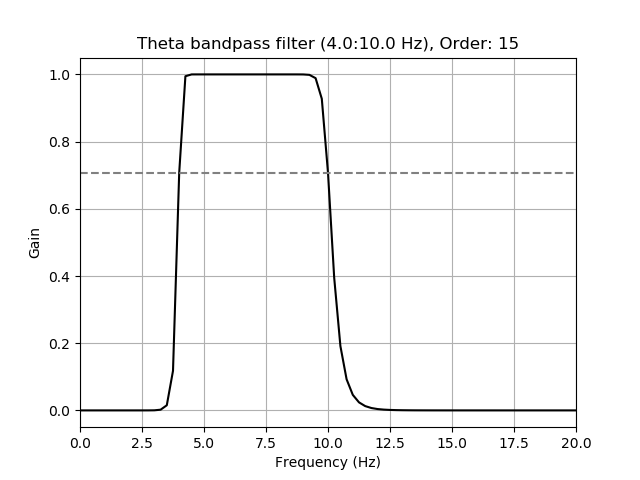

<IPython.core.display.Javascript object>


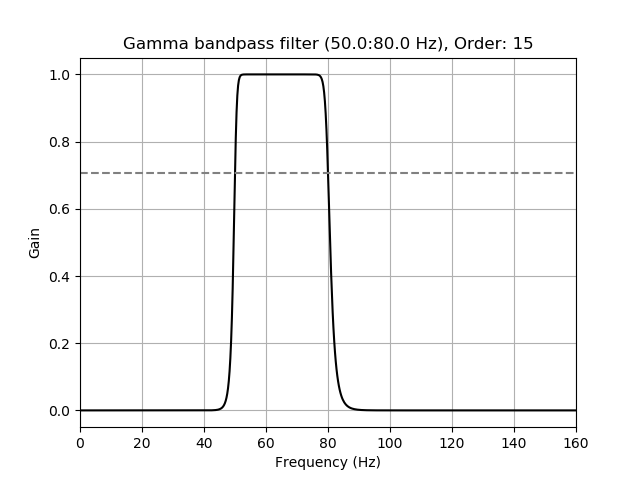

In [6]:
for filter_label, filter_band in filter_band_dict.iteritems():
    sos_dict[filter_label] = get_butter_bandpass_filter(filter_band, sampling_rate, order=filter_order, filter_label=filter_label, plot=True)

1


/Users/milsteina/anaconda2/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


<IPython.core.display.Javascript object>


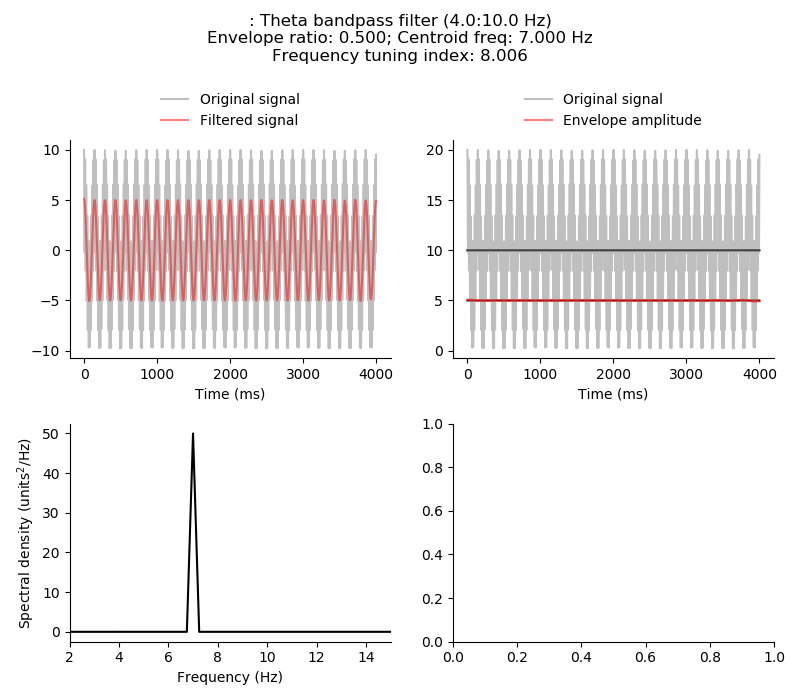

1


<IPython.core.display.Javascript object>


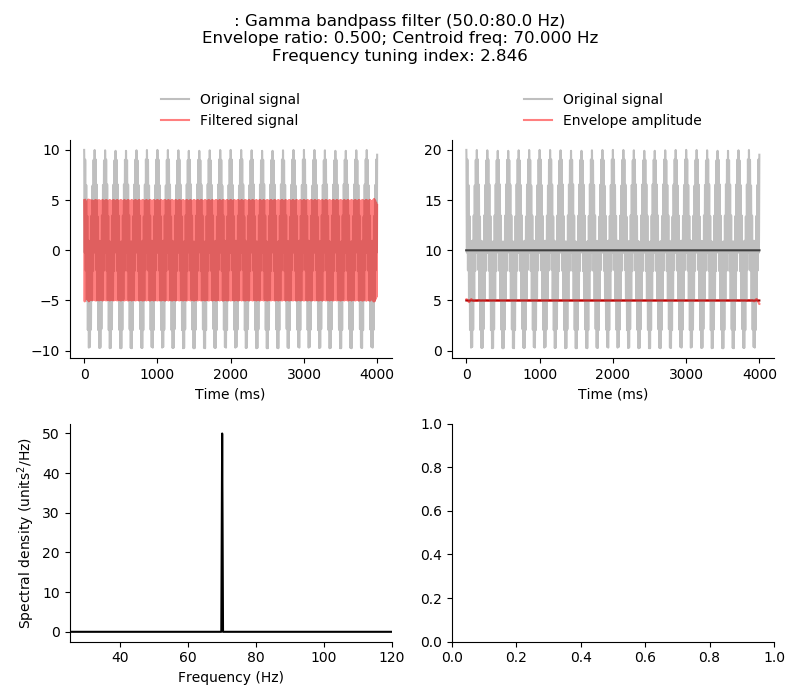

In [7]:
filtered_signal_dict, envelope_dict, envelope_ratio_dict, centroid_freq_dict, freq_tuning_index_dict = \
    {}, {}, {}, {}, {}
for filter_label in filter_band_dict:
    filtered_signal_dict[filter_label], envelope_dict[filter_label], envelope_ratio_dict[filter_label], \
    centroid_freq_dict[filter_label], freq_tuning_index_dict[filter_label] = \
    get_bandpass_filtered_signal_stats(rate, t, sos_dict[filter_label], filter_band_dict[filter_label], 
                                       filter_label=filter_label, pad=True, plot=True)

In [8]:
spike_trains = []
binned_spike_count = []
for i in xrange(num_cells):
    this_spike_train = get_inhom_poisson_spike_times_by_thinning(rate, t, dt=dt, generator=local_random)
    spike_trains.append(this_spike_train)
    this_binned_spike_count = np.zeros_like(t)
    indexes = []
    ti = 0
    for this_spike in this_spike_train:
        i = np.where(t[ti:] >= this_spike)[0]
        if np.any(i):
            indexes.append(i[0])
    this_binned_spike_count[indexes] = 1.
    binned_spike_count.append(this_binned_spike_count)
mean_rate_from_spike_count = np.divide(np.mean(binned_spike_count, axis=0), dt/1000.)

1


<IPython.core.display.Javascript object>


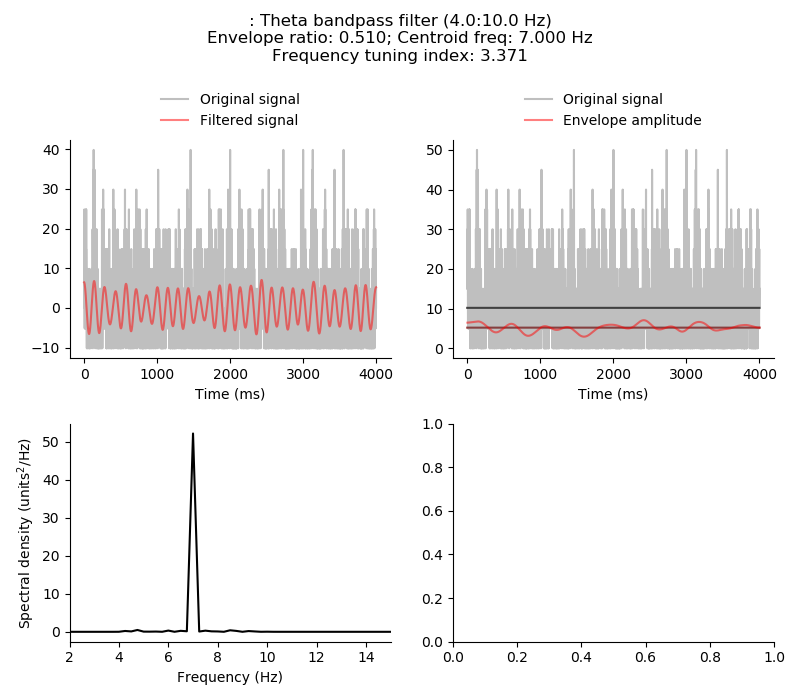

1


<IPython.core.display.Javascript object>


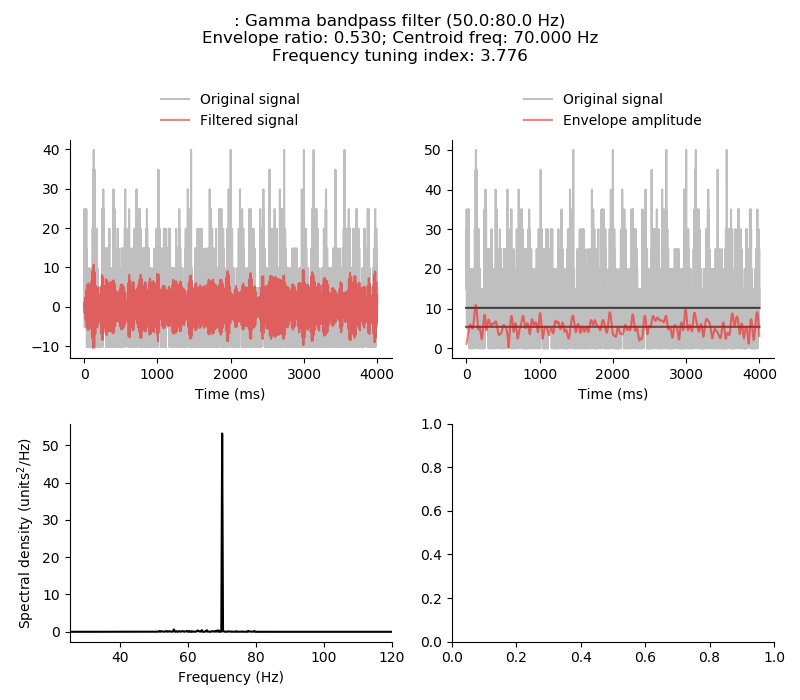

In [9]:
for filter_label in filter_band_dict:
    filtered_signal_dict[filter_label], envelope_dict[filter_label], envelope_ratio_dict[filter_label], \
    centroid_freq_dict[filter_label], freq_tuning_index_dict[filter_label] = \
    get_bandpass_filtered_signal_stats(mean_rate_from_spike_count, t, sos_dict[filter_label], 
                                       filter_band_dict[filter_label], filter_label=filter_label, pad=True, plot=True)